# Behavior Cloning Training Model




Overall approach to behavior cloning

* Load training data: Reads file names and returns a list of batches
 * Read CSV file
 * Read X_train_files, y_train_angle
 * Convert into X_train and y_train dataset
 * Visualize random training data
 * Analyze training data

* Preprocess training data : Takes a batch and returns a preprocessed batch
 * Shuffling
 * Convert to grayscale / normalize
 * Split training data
 * Augment data

* Create a network
 * Test with a two layer feed forward network

## Loading training data

In [1]:
#imports
from PIL import Image
import numpy as np
import os
import random

#constants
PATH_OF_IMAGES = './data/simulator/IMG'
PATH_OF_CSV = './data/simulator/driving_log.csv'
IMAGE_TYPE = 'center'
n_classes = 21

In [2]:
#load csv file
import csv

# returns a tuple of X_train_image_filenames, y_train_angle
def readCsv():
    csvData = np.array(list(csv.reader(open(PATH_OF_CSV))))
    print('Shape of CSV file {0}'.format(csvData.shape))
    X_train_image_filenames = csvData[:,0]
    y_train_angle = (csvData[:,3]).astype(np.float32)
    return X_train_image_filenames, y_train_angle

X_train_image_filenames, y_train = readCsv()

Shape of CSV file (323, 7)


In [3]:
#load training data and images
def loadImages(type):
    files = os.listdir(PATH_OF_IMAGES)
    files = list(filter(lambda k: type in k, files))
    print('{0} {1} images available in training data'.format(len(files), type))
    return files


#takes a list of image filenames 
def loadAllImages(files):
    image_array = []
    for image in files:
        img = Image.open(image)
        np_img = np.array(img, dtype=np.float32)
        image_array.append(np_img)
    image_array = np.array(image_array)
    assert (random.choice(image_array).shape == (160,320,3))
    return image_array

X_train = loadAllImages(X_train_image_filenames)
print(X_train.shape)

(323, 160, 320, 3)


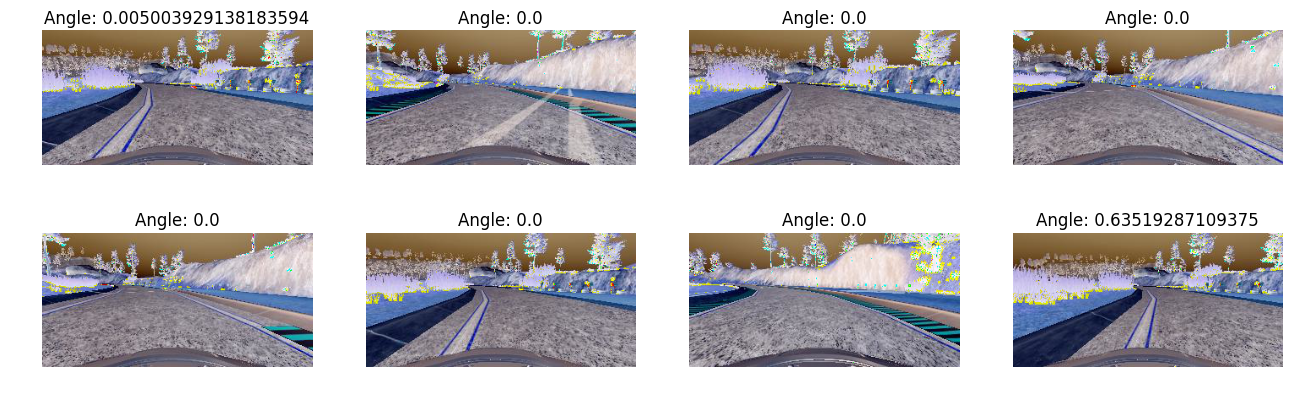

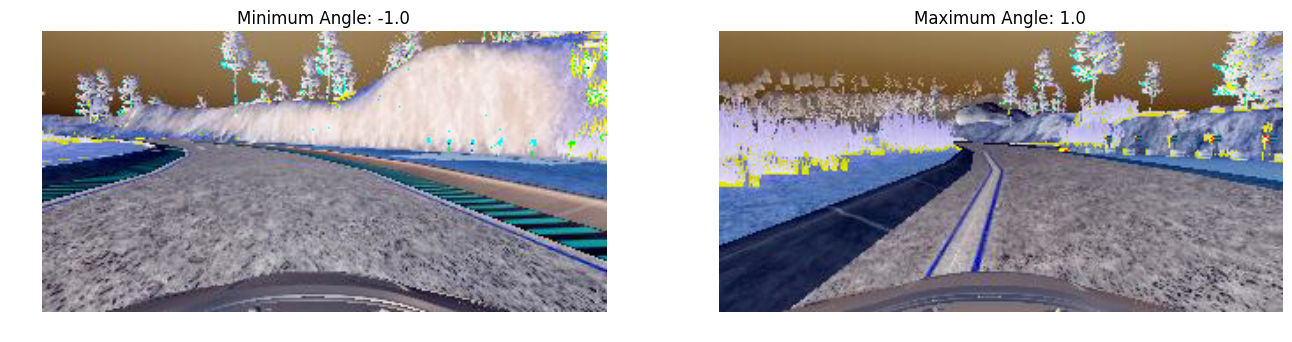

In [4]:
#visual a random sample of training data
#visualization strategy
#  - 4 random samples
#  - 3 samples - lowest steering angle, highest steering angle and zero steering angle
#  - Histogram of y

import matplotlib.pyplot as plt
%matplotlib inline

def plotRandomImage(image_array, angle_array):
    X_random_16 = np.random.choice(len(image_array), 8)
    plt.figure(figsize=(16,10))
    for ii,idx in enumerate(X_random_16):
        plt.subplot(4,4, ii+1)
        plt.axis('off')
        plt.title('Angle: {}'.format(angle_array[idx]))
        plt.imshow(image_array[idx])

#create histogram of y
#display min,max steering and image
def plotMinMax():
    y_train_min = np.argmin(y_train)
    y_train_max = np.argmax(y_train)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(X_train[y_train_min])
    plt.title('Minimum Angle: {}'.format(y_train[y_train_min]))
    plt.subplot(1,2, 2)
    plt.axis('off')
    plt.title('Maximum Angle: {}'.format(y_train[y_train_max]))
    plt.imshow(X_train[y_train_max])

plotRandomImage(X_train, y_train)
plotMinMax()


## Preprocess training data

In [5]:
#Shuffling training data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
y_train = np.round(y_train, decimals=1)
print(np.unique(y_train))

[-1.         -0.89999998 -0.80000001 -0.69999999 -0.60000002 -0.5
 -0.40000001 -0.30000001 -0.2        -0.1         0.          0.30000001
  0.40000001  0.60000002  0.69999999  0.80000001  1.        ]


(323,)
[ 0  1  3  5  6  7  8  9 10 13 14 16 17 18 20]


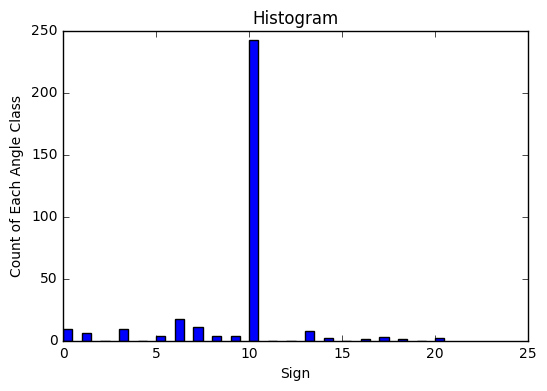

In [6]:
#convery y_train into classes
y_train_classes = ((y_train+1)*10).astype(np.int32)
print(y_train_classes.shape)
print(np.unique(y_train_classes))

def plotYHistorygram(y_train):
    fig, ax = plt.subplots()
    ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='b')
    ax.set_xlabel('Sign')
    ax.set_ylabel('Count of Each Angle Class')
    ax.set_title('Histogram')
    plt.show()
    
plotYHistorygram(y_train_classes)

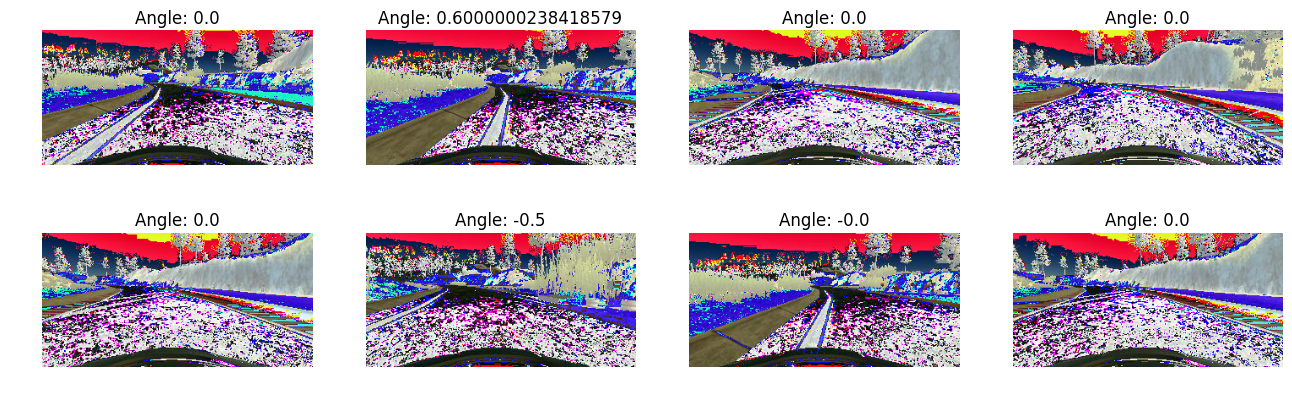

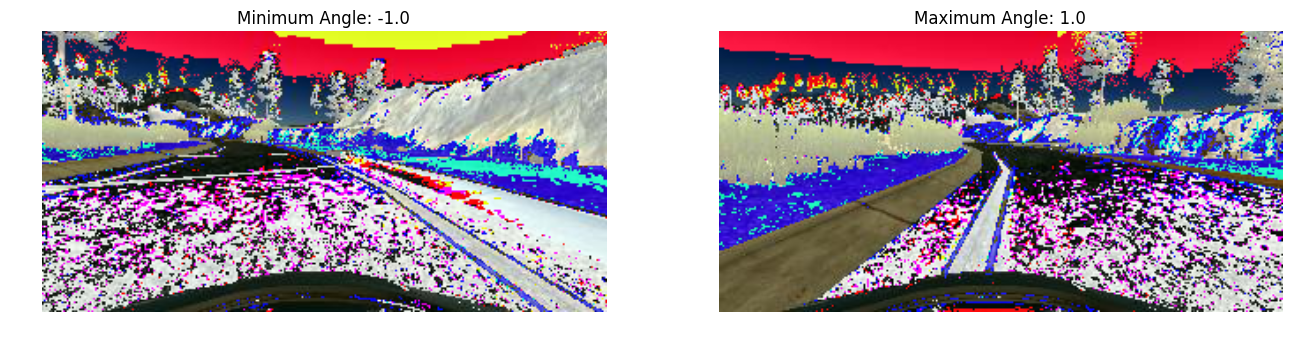

In [7]:
#normalize the data between range -0.5 to 0.5
def normalize_between_plus_min_05(image_data):
    image_data = image_data.astype('float32')
    image_data = image_data / 255 - 0.5
    return image_data

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_train = normalize_between_plus_min_05(X_train)
plotRandomImage(X_train, y_train)
plotMinMax()

In [8]:
def removeChannels(images):
    print(images.shape)
    newImages = np.reshape(images[::,::,::,-1], (-1, 160,320,1))
    print(newImages.shape)
    print(newImages)
#     plotRandomImage(newImages, y_train)
    return newImages

X_train = removeChannels(X_train)

(323, 160, 320, 3)
(323, 160, 320, 1)
[[[[ 0.2764706 ]
   [ 0.2764706 ]
   [ 0.27254903]
   ..., 
   [-0.21372548]
   [-0.28039217]
   [-0.30392158]]

  [[ 0.2764706 ]
   [ 0.2764706 ]
   [ 0.2764706 ]
   ..., 
   [-0.27254903]
   [-0.32745099]
   [-0.34705883]]

  [[ 0.28039217]
   [ 0.28039217]
   [ 0.28039217]
   ..., 
   [-0.27254903]
   [-0.33137256]
   [-0.34313726]]

  ..., 
  [[-0.06078431]
   [-0.09999999]
   [ 0.00980395]
   ..., 
   [-0.02941176]
   [-0.08039215]
   [-0.17058823]]

  [[-0.03333333]
   [-0.04509804]
   [-0.14705881]
   ..., 
   [-0.13137254]
   [-0.06862745]
   [-0.15098038]]

  [[-0.04117647]
   [-0.18235293]
   [-0.17843136]
   ..., 
   [-0.03333333]
   [-0.09999999]
   [-0.08039215]]]


 [[[ 0.26078433]
   [ 0.26078433]
   [ 0.25686276]
   ..., 
   [-0.25686276]
   [-0.27254903]
   [-0.28431374]]

  [[ 0.26078433]
   [ 0.26078433]
   [ 0.26078433]
   ..., 
   [-0.27254903]
   [-0.29215688]
   [-0.30392158]]

  [[ 0.27254903]
   [ 0.27254903]
   [ 0.2725490

In [9]:
#Split the data into training/validation/testing sets here.

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation, y_train_classes, y_validation_classes = train_test_split(
    X_train, y_train, y_train_classes, test_size=0.20, random_state=42)

print('Shape of training images {}', X_train.shape)
print('Shape of validation images {}', X_validation.shape)

Shape of training images {} (258, 160, 320, 1)
Shape of validation images {} (65, 160, 320, 1)


In [10]:
#Augment data
import cv2

def rotate(img, angle_range):
    #angle_rotation = np.random.uniform(angle_range)-angle_range/2
    angle_rotation = angle_range
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),angle_rotation,1)
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    return img

def rotate_test():
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    img = rotate(image, 10)
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    
# rotate_test()
AUGMENT_BY_ROTATION_DEGREES = 10

def generateOptionalData(x,y,angle):
    X_rotated_images = []
    y_rotated_images = []
    for img,yy in zip(x, y):
        rotated_image = rotate(img, angle)
        X_rotated_images.append(rotated_image)
        y_rotated_images.append(yy)
    return X_rotated_images, y_rotated_images

# X_rotated_images, y_rotated_images = generateOptionalData(X_train,y_train_classes,AUGMENT_BY_ROTATION_DEGREES)
# X_t_images = np.array(X_rotated_images)
# y_t_images = np.array(y_rotated_images)
# print('Generated {0} images by rotating {1} degrees'.format(len(X_t_images), AUGMENT_BY_ROTATION_DEGREES))

# X_train = np.concatenate((X_train, X_t_images))
# y_train_classes = np.concatenate((y_train_classes, y_t_images))

print('Shape of X_train: {0}, shape of y_train = {1}'.format(X_train.shape, y_train_classes.shape))
print('Shape of validation images: {0}'.format(X_validation.shape))

Shape of X_train: (258, 160, 320, 1), shape of y_train = (258,)
Shape of validation images: (65, 160, 320, 1)


## Build a network

Two layer feed forward network

In [11]:
#convert y_train_classes into vector Y_train
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train_classes, n_classes)
Y_validation = np_utils.to_categorical(y_validation_classes, n_classes)

#flatten training data
X_train_flat = X_train.reshape(-1, 160*320*1)
X_validation_flat = X_validation.reshape(-1, 160*320*1)
print(X_train_flat.shape)

Using TensorFlow backend.


(258, 51200)


In [12]:
from keras.layers import Conv2D, Flatten
from keras.layers.core import Dropout
from keras.layers.pooling import MaxPooling2D

def createTwoLayerFeedForward():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(160*320*3,)))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

def saurabhSimpleconvNet():
    model = Sequential()
    model.add(Conv2D(6, 5, 5, input_shape=(160, 320,3), activation='relu'))
    model.add(Conv2D(32, 64, 64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model    


def saurabhSimpleconvNet1():
    model = Sequential()
    model.add(Conv2D(6, 5, 5, input_shape=(160, 320,3), activation='relu'))
    model.add(Conv2D(32, 64, 64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, 32, 32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, 16, 16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, 4, 4,activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model    


def otherModel():
    # number of convolutional filters to use
    nb_filters1 = 16
    nb_filters2 = 8
    nb_filters3 = 4
    nb_filters4 = 2

    # size of pooling area for max pooling
    pool_size = (2, 2)

    # convolution kernel size
    kernel_size = (3, 3)

    # Initiating the model
    model = Sequential()

    # Starting with the convolutional layer
    # The first layer will turn 1 channel into 16 channels
    model.add(Conv2D(nb_filters1, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=(160, 320,1)))
    # Applying ReLU
    model.add(Activation('relu'))
    # The second conv layer will convert 16 channels into 8 channels
    model.add(Conv2D(nb_filters2, kernel_size[0], kernel_size[1]))
    # Applying ReLU
    model.add(Activation('relu'))
    # The second conv layer will convert 8 channels into 4 channels
    model.add(Conv2D(nb_filters3, kernel_size[0], kernel_size[1]))
    # Applying ReLU
    model.add(Activation('relu'))
    # The second conv layer will convert 4 channels into 2 channels
    model.add(Conv2D(nb_filters4, kernel_size[0], kernel_size[1]))
    # Applying ReLU
    model.add(Activation('relu'))
    # Apply Max Pooling for each 2 x 2 pixels
    model.add(MaxPooling2D(pool_size=pool_size))
    # Apply dropout of 25%
    model.add(Dropout(0.25))

    # Flatten the matrix. The input has size of 360
    model.add(Flatten())
    # Input 360 Output 16
    model.add(Dense(21))
    # Applying ReLU
    model.add(Activation('relu'))
    # Input 16 Output 16
    model.add(Dense(21))
    # Applying ReLU
    model.add(Activation('relu'))
    # Input 16 Output 16
    model.add(Dense(21))
    # Applying ReLU
    model.add(Activation('relu'))
    # Apply dropout of 50%
    model.add(Dropout(0.5))
    # Input 16 Output 1
    model.add(Dense(n_classes))

    # Print out summary of the model
    model.summary()
    return model

In [13]:
#Build a two-layer feedforward neural network with Keras here.
from keras.models import Sequential
from keras.layers import Dense, Input, Activation

print(X_train.shape)
#model = createTwoLayerFeedForward()
#model = saurabhSimpleconvNet()
model = otherModel()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# history = model.fit(X_train_flat, Y_train,
#                     batch_size=128, nb_epoch=1,
#                     verbose=1, validation_data=(X_validation_flat, Y_validation))

# history = model.fit(X_train, Y_train,
#                     batch_size=128, nb_epoch=1,
#                     verbose=1, validation_data=(X_validation, Y_validation))


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

### Model training
history = model.fit(X_train, Y_train,
                    batch_size=128, nb_epoch=1,
                    verbose=1, validation_data=(X_validation, Y_validation))


(258, 160, 320, 1)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 158, 318, 16)  160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 158, 318, 16)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 156, 316, 8)   1160        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 156, 316, 8)   0           convolution2d_2[0][0]            
________________________________________________________________________

In [14]:
json_string = model.to_json()
with open("model.json", "w") as text_file:
   print(json_string, file=text_file)



# model.save_weights('my_model_weights.h5')
# model.save('my_model.h5')

In [15]:
from keras.models import load_model


model1 = load_model('model.h5')

In [16]:
json_string = model.to_json()
with open("model.json", "w") as text_file:
   print(json_string, file=text_file)